# Presto Geospatial Queries

- [8.20. Geospatial Functions](https://prestodb.io/docs/current/functions/geospatial.html)
- PR 2018 - [Broadcast spatial join #9474](https://github.com/prestodb/presto/pull/9474)
- PR 2019 - [Use Flatbush RTree for Spatial Joins #13079](https://github.com/prestodb/presto/pull/13079)
- 2019 - [Geospatial Query Performance Test of Presto and PostGIS](https://medium.com/@uprush/geospatial-query-performance-test-of-presto-and-postgis-d9bf2825e56a)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import shapely.wkt
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import prestodb

prestodb.__version__, gpd.__version__

('0.7.0', '0.8.0')

In [3]:
PRESTO_CONNECTION = dict(
    host='localhost',
    port=8080,
    user='hadoop',
    catalog='hive',
    schema='default'
)

In [4]:
def run_query(verbose=True, **args):
    with prestodb.dbapi.connect(**args) as connection:
        cursor = connection.cursor()
        cursor.execute(query)

        items = cursor.fetchall()
        columns = [v[0] for v in cursor.description]
        df = pd.DataFrame(items, columns=columns)

        if verbose:
            stats = cursor.stats
            print(stats['state'], 'in', stats['elapsedTimeMillis'], 'ms')
            print('num nodes :', stats['nodes'])
            print("Query :", stats['queryId'])
            print("Splits :", stats['rootStage']['completedSplits'], "/", stats['rootStage']['totalSplits'])

    return df

In [5]:
query = "SELECT * FROM gdelt_csv LIMIT 10"

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')

FINISHED in 1901 ms
num nodes : 3
Query : 20200915_183735_00002_w9jmr
Splits : 17 / 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   event_date       10 non-null     object
 1   event_code       10 non-null     object
 2   event_base_code  10 non-null     object
 3   event_root_code  10 non-null     object
 4   lat              10 non-null     object
 5   lon              10 non-null     object
 6   source_url       10 non-null     object
dtypes: object(7)
memory usage: 5.2 KB


In [8]:
query = """
    SELECT ST_Point(lon, lat) AS pt 
    FROM gdelt_csv 
    LIMIT 10
"""

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')

FINISHED in 5317 ms
num nodes : 3
Query : 20200916_120556_00000_w9jmr
Splits : 33 / 33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pt      10 non-null     object
dtypes: object(1)
memory usage: 896.0 bytes


In [7]:
%%time
query = """
    SELECT event_date, event_root_code, ST_Point(lon, lat) AS pt 
    FROM gdelt_csv
    LIMIT 10
"""

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')

FINISHED in 1131 ms
num nodes : 1
Query : 20200914_151657_00039_g9zht
Splits : 33 / 33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   event_date       10 non-null     object
 1   event_root_code  10 non-null     object
 2   pt               10 non-null     object
dtypes: object(3)
memory usage: 2.2 KB
CPU times: user 45.6 ms, sys: 0 ns, total: 45.6 ms
Wall time: 1.18 s


# Query all Points in Bounding Box or Polygon

In [11]:
EXTENT = [-126.6,23.1,-64.4,49.3]
extent_wkt = shapely.geometry.box(*EXTENT).wkt

In [16]:
%%time
query = """
    SELECT event_date, event_root_code, ST_Point(lon, lat) AS geom
    FROM gdelt_csv
    WHERE ST_Intersects(ST_Point(lon, lat), ST_GeometryFromText('{}'))
""".format(extent_wkt)

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')
df.head()

FINISHED in 84754 ms
num nodes : 1
Query : 20200914_151934_00041_g9zht
Splits : 16 / 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8269043 entries, 0 to 8269042
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   event_date       object
 1   event_root_code  object
 2   geom             object
dtypes: object(3)
memory usage: 1.6 GB
CPU times: user 38 s, sys: 7.72 s, total: 45.8 s
Wall time: 1min 42s


,event_date,event_root_code,geom
0,2020-01-06,19,POINT (-77.0364 38.8951)
1,2020-01-06,19,POINT (-77.0364 38.8951)
2,2020-01-06,19,POINT (-77.0364 38.8951)
3,2020-01-06,8,POINT (-77.0364 38.8951)
4,2020-01-06,4,POINT (-98.5795 39.828175)


In [17]:
df['geom'] = df['geom'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8269043 entries, 0 to 8269042
Data columns (total 3 columns):
 #   Column           Dtype   
---  ------           -----   
 0   event_date       object  
 1   event_root_code  object  
 2   geom             geometry
dtypes: geometry(1), object(2)
memory usage: 1.1 GB


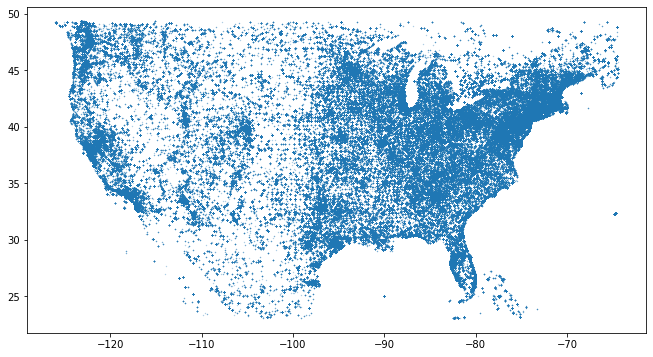

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf.plot(ax=ax, alpha=0.5, markersize=0.1);

# Bing Tiles

In [61]:
%%time
query = """
    WITH counts AS (
      SELECT
        COUNT(*) AS cnt,
        bing_tile_at(lat, lon, 6) AS tile
      FROM gdelt_csv
      WHERE -85 < lat AND lat < 85
      GROUP BY 2
    )
    
    SELECT 
      cnt, 
      tile, 
      bing_tile_polygon(tile) AS geom
    FROM counts
""".format(extent_wkt)

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')
df.head()

FINISHED in 12601 ms
num nodes : 1
Query : 20200914_155900_00057_g9zht
Splits : 16 / 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cnt     1116 non-null   int64 
 1   tile    1115 non-null   object
 2   geom    1115 non-null   object
dtypes: int64(1), object(2)
memory usage: 466.2 KB
CPU times: user 69.8 ms, sys: 8.08 ms, total: 77.9 ms
Wall time: 12.7 s


,cnt,tile,geom
0,85034,"{'x': 33, 'y': 29, 'zoom': 6}","POLYGON ((5.625 11.178401873711778, 11.25 11.1..."
1,67910,"{'x': 43, 'y': 25, 'zoom': 6}","POLYGON ((61.875 31.952162238024954, 67.5 31.9..."
2,110190,"{'x': 15, 'y': 22, 'zoom': 6}","POLYGON ((-95.625 45.08903556483103, -90 45.08..."
3,43798,"{'x': 19, 'y': 22, 'zoom': 6}","POLYGON ((-73.125 45.08903556483103, -67.5 45...."
4,9655,"{'x': 19, 'y': 38, 'zoom': 6}","POLYGON ((-73.125 -36.597889133070225, -67.5 -..."


In [62]:
df = df.dropna(subset=['geom'])
df['geom'] = df['geom'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1115 entries, 0 to 1115
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   cnt     1115 non-null   int64   
 1   tile    1115 non-null   object  
 2   geom    1115 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 270.0 KB


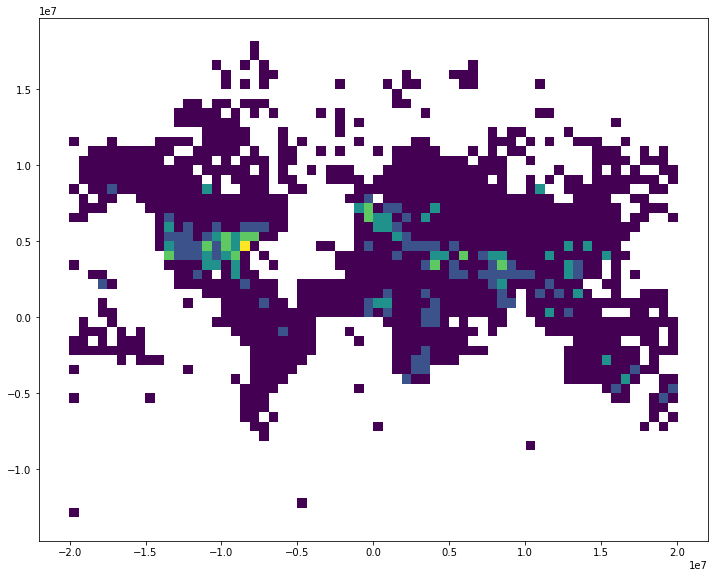

In [63]:
gdf.to_crs(epsg=3857).plot(column='cnt', 
                           cmap='viridis', 
                           scheme='naturalbreaks', k=5,
                           figsize=(12, 10));

# Spatial Join

In [76]:
%%time
query = """
    SHOW TABLES
"""

df = run_query(query, **PRESTO_CONNECTION)
df.head()

FINISHED in 3839 ms
num nodes : 3
Query : 20200915_172706_00000_w9jmr
Splits : 1 / 1
CPU times: user 46.8 ms, sys: 0 ns, total: 46.8 ms
Wall time: 4.2 s


,Table
0,gdelt_csv
1,gdelt_parquet
2,ne_10_states_provinces_parquet
3,ne_110_countries_parquet


In [6]:
%%time
query = """
    WITH countries AS (
      SELECT 
        ne_id,
        iso_a2,
        ST_GeomFromBinary(geometry) AS geometry
      FROM ne_110_countries_parquet
    ), points AS (
       SELECT
         event_root_code, 
         ST_Point(lon, lat) AS point
       FROM gdelt_csv
    )
    
    SELECT 
      countries.ne_id,
      countries.iso_a2,
      points.event_root_code,
      COUNT(*) AS cnt
    FROM points, countries
    WHERE ST_Contains(countries.geometry, points.point)
    GROUP BY (
      countries.ne_id, 
      countries.iso_a2,
      points.event_root_code
    )
"""

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')
df.head()

FINISHED in 129502 ms
num nodes : 3
Query : 20200915_183751_00003_w9jmr
Splits : 16 / 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82401 entries, 0 to 82400
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ne_id            82401 non-null  int64 
 1   iso_a2           82401 non-null  object
 2   event_root_code  82401 non-null  object
 3   cnt              82401 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 10.8 MB
CPU times: user 1.26 s, sys: 407 ms, total: 1.66 s
Wall time: 2min 10s


,ne_id,iso_a2,event_root_code,cnt
0,1159311631,OM,181,7
1,1159308125,SS,80,10
2,1159311363,SO,33,20
3,1159308877,KE,16,835
4,1159315139,YE,181,7


## Single Node

    FINISHED in 114342 ms
    num nodes : 1
    Query : 20200915_110336_00014_g9zht
    Splits : 16 / 16

    CPU times: user 694 ms, sys: 25.5 ms, total: 719 ms
    Wall time: 1min 54s
    
## Three Nodes (Two Worker Nodes)

    FINISHED in 314770 ms
    num nodes : 2
    Query : 20200915_171804_00003_hv23u
    Splits : 16 / 16

    CPU times: user 2.21 s, sys: 200 ms, total: 2.41 s
    Wall time: 5min 15s
    
## Three Nodes

    FINISHED in 176433 ms
    num nodes : 3
    Query : 20200915_172737_00001_w9jmr
    Splits : 16 / 16

    CPU times: user 5.19 s, sys: 72.9 ms, total: 5.26 s
    Wall time: 3min

In [37]:
%%time
query = """
    WITH countries AS (
      SELECT 
        ne_id,
        iso_a2,
        ST_GeomFromBinary(geometry) AS geometry
      FROM ne_10_states_provinces_parquet
    ), points AS (
       SELECT
         event_root_code, 
         ST_Point(lon, lat) AS point
       FROM gdelt_csv
    )
    
    SELECT 
      countries.ne_id,
      countries.iso_a2,
      points.event_root_code,
      COUNT(*) AS cnt
    FROM points, countries
    WHERE ST_Contains(countries.geometry, points.point)
    GROUP BY (
      countries.ne_id, 
      countries.iso_a2,
      points.event_root_code
    )
"""

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')
df.head()

FINISHED in 190166 ms
num nodes : 1
Query : 20200915_113827_00020_g9zht
Splits : 16 / 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82401 entries, 0 to 82400
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ne_id            82401 non-null  int64 
 1   iso_a2           82401 non-null  object
 2   event_root_code  82401 non-null  object
 3   cnt              82401 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 10.8 MB
CPU times: user 1.25 s, sys: 41.2 ms, total: 1.3 s
Wall time: 3min 10s


,ne_id,iso_a2,event_root_code,cnt
0,1159313611,RU,11,10970
1,1159315341,US,19,7788
2,1159311875,IN,5,11992
3,1159315313,US,6,2149
4,1159311875,IN,9,3782


In [7]:
%%time
query = """
    WITH countries AS (
      SELECT 
        ne_id,
        iso_a2,
        ST_GeomFromBinary(geometry) AS geometry
      FROM ne_10_states_provinces_parquet
    ), points AS (
       SELECT
         event_root_code, 
         ST_Point(lon, lat) AS point
       FROM gdelt_csv
    ), counts AS (
      SELECT 
        countries.ne_id,
        countries.iso_a2,
        points.event_root_code,
        COUNT(*) AS cnt
      FROM points, countries
      WHERE ST_Contains(countries.geometry, points.point)
      GROUP BY (
        points.event_root_code,
        countries.ne_id, 
        countries.iso_a2
      )
    )
    
    SELECT 
      counts.ne_id,
      counts.iso_a2,
      counts.event_root_code,
      counts.cnt,
      countries.geometry
    FROM
      counts,
      countries
    WHERE
      counts.ne_id = countries.ne_id
"""

df = run_query(query, **PRESTO_CONNECTION)
df.info(memory_usage='deep')
df.head()

FINISHED in 419318 ms
num nodes : 3
Query : 20200915_184023_00004_w9jmr
Splits : 16 / 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82401 entries, 0 to 82400
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ne_id            82401 non-null  int64 
 1   iso_a2           82401 non-null  object
 2   event_root_code  82401 non-null  object
 3   cnt              82401 non-null  int64 
 4   geometry         82401 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.2 GB
CPU times: user 29.6 s, sys: 7.77 s, total: 37.4 s
Wall time: 7min 18s


,ne_id,iso_a2,event_root_code,cnt,geometry
0,1159313755,UG,40,78,MULTIPOLYGON (((33.52771634883044 3.7714305725...
1,1159311379,SO,70,18,MULTIPOLYGON (((46.46696287700007 6.5382924060...
2,1159313651,CG,36,33,MULTIPOLYGON (((18.626387166000086 3.476868998...
3,1159308957,CF,70,9,MULTIPOLYGON (((20.456712866805333 4.524815862...
4,1159309145,YE,161,46,MULTIPOLYGON (((51.98568874883665 18.979731806...


## Single Node

    FINISHED in 450019 ms
    num nodes : 1
    Query : 20200915_124337_00031_g9zht
    Splits : 16 / 16

    CPU times: user 30.8 s, sys: 1.58 s, total: 32.4 s
    Wall time: 7min 47s
    
## Three Nodes

    FINISHED in 419318 ms
    num nodes : 3
    Query : 20200915_184023_00004_w9jmr
    Splits : 16 / 16

    CPU times: user 29.6 s, sys: 7.77 s, total: 37.4 s
    Wall time: 7min 18s

In [60]:
df_counts = df.groupby(['ne_id', 'iso_a2', 'geometry'])['cnt'].sum().reset_index().copy()
df_counts['geometry'] = df_counts['geometry'].apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df_counts, geometry='geometry', crs='epsg:4326')
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ne_id     4075 non-null   int64   
 1   iso_a2    4075 non-null   object  
 2   geometry  4075 non-null   geometry
 3   cnt       4075 non-null   int64   
dtypes: geometry(1), int64(2), object(1)
memory usage: 330.4 KB


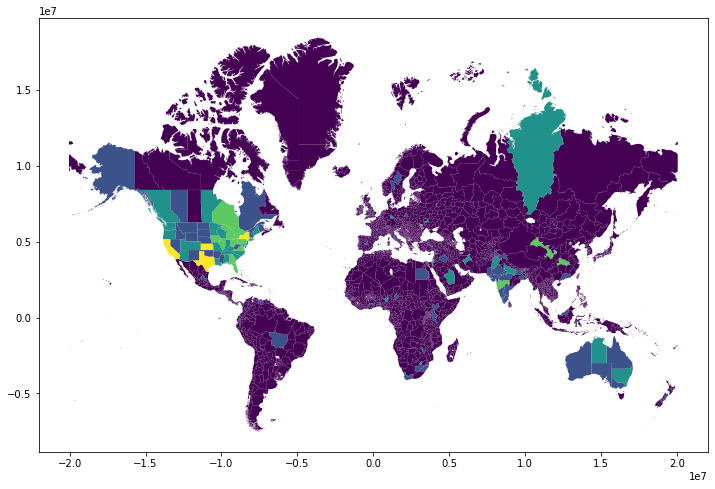

In [71]:
# Remove Antarctica
mask = gdf['iso_a2'] != 'AQ'

gdf[mask].to_crs(epsg=3857).plot(column='cnt', 
                                 cmap='viridis', 
                                 scheme='naturalbreaks', k=5,
                                 figsize=(12, 10));